In [1]:
from google.colab import drive
drive.mount('/gdrive/')
%cd /gdrive

Mounted at /gdrive/
/gdrive


In [2]:
ls

MyDrive/  Shareddrives/


In [3]:
cd/gdrive/MyDrive/snake/

/gdrive/MyDrive/snake


In [4]:
ls

agkistrodon-contortrix/  crotalus-ruber/       heterodon-platirhinos/
agkistrodon-piscivorus/  crotalus-scutulatus/  lampropeltis-californiae/
coluber-constrictor/     crotalus-viridis/     lampropeltis-triangulum/
crotalus-atrox/          diadophis-punctatus/  masticophis-flagellum/
crotalus-horridus/       haldea-striatula/


In [5]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.preprocessing.image import load_img

In [6]:
import os
import PIL
import pathlib
import pandas as pd
import numpy as np
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import preprocessing
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.python.ops.numpy_ops import np_utils

In [25]:
BATCH_SIZE = 62
IMAGE_SIZE = 256
EPOCHS=15
CHANNELS=3

In [8]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "/gdrive/MyDrive/snake",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 4945 files belonging to 14 classes.


In [9]:
class_names = dataset.class_names
class_names

['agkistrodon-contortrix',
 'agkistrodon-piscivorus',
 'coluber-constrictor',
 'crotalus-atrox',
 'crotalus-horridus',
 'crotalus-ruber',
 'crotalus-scutulatus',
 'crotalus-viridis',
 'diadophis-punctatus',
 'haldea-striatula',
 'heterodon-platirhinos',
 'lampropeltis-californiae',
 'lampropeltis-triangulum',
 'masticophis-flagellum']

In [10]:
len(dataset)

80

In [11]:
for image_batch, label_batch in dataset.take(1):
  print(image_batch.shape)
  print(image_batch[1])
  print(label_batch.numpy())

(62, 256, 256, 3)
tf.Tensor(
[[[ 94.00586   70.00586   34.01758 ]
  [ 95.        71.01758   37.052734]
  [ 94.94141   71.91211   40.029297]
  ...
  [ 52.029297  36.029297  22.941406]
  [ 50.035156  36.        23.      ]
  [ 50.        36.        23.      ]]

 [[105.48545   81.48545   45.489708]
  [109.67811   85.6733    50.468597]
  [111.44013   87.174706  55.909958]
  ...
  [ 57.797073  41.797073  27.473053]
  [ 55.765625  41.73047   28.708084]
  [ 55.73047   41.73047   28.730469]]

 [[111.25072   86.461655  50.071747]
  [118.0458    93.23916   57.72158 ]
  [120.458984  94.71078   64.15852 ]
  ...
  [ 73.17966   57.179657  42.15036 ]
  [ 71.265625  57.23047   44.195312]
  [ 71.23047   57.23047   44.23047 ]]

 ...

 [[128.1987    97.00303   57.180763]
  [116.82988   88.17861   47.41494 ]
  [116.28288   85.13672   47.32569 ]
  ...
  [114.647766  95.279106  72.28871 ]
  [119.884285 101.057236  76.3001  ]
  [126.1472   104.950294  81.15537 ]]

 [[138.37518  106.74965   64.656075]
  [125.7

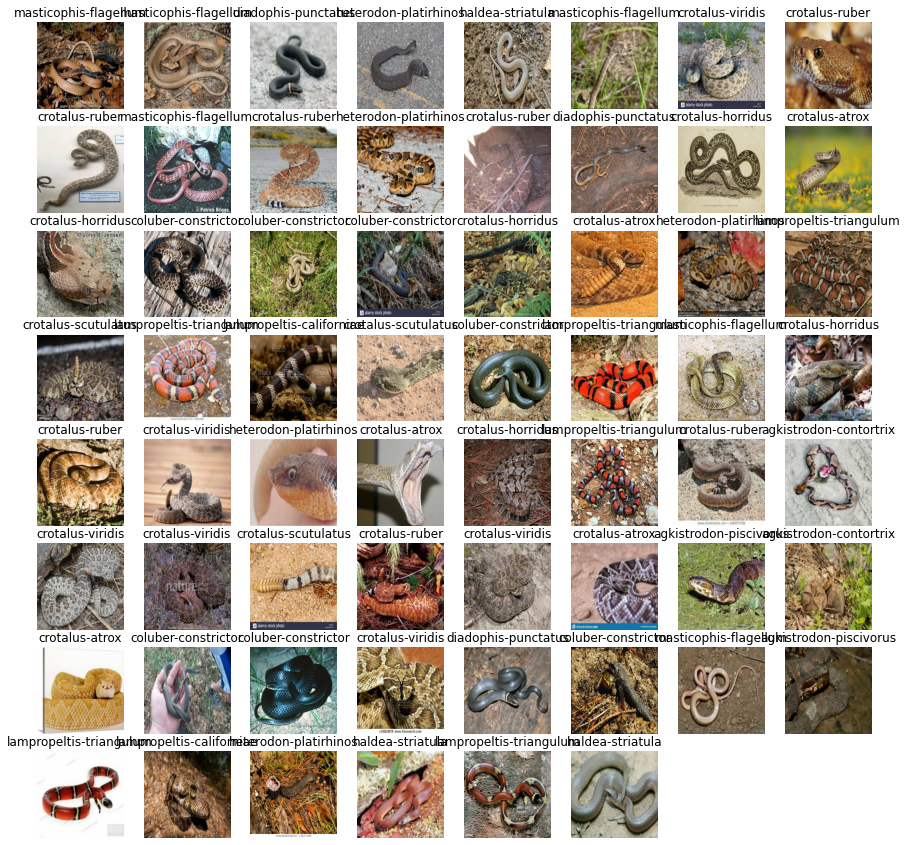

In [12]:
plt.figure(figsize=(15, 15))
for image_batch, labels_batch in dataset.take(1):
    for i in range(BATCH_SIZE):
        ax = plt.subplot(8, 8, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

In [13]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    ds_size = len(ds)
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    # Autotune all the 3 datasets 
    train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
    val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
    test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
    return train_ds, val_ds, test_ds

In [14]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [15]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])

In [16]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

In [21]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 14

model = models.Sequential([
    resize_and_rescale,
    # data_augmentation,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])
model.build(input_shape=input_shape)

In [22]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [23]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 256, 256, 3)       0         
                                                                 
 conv2d_6 (Conv2D)           (62, 254, 254, 32)        896       
                                                                 
 max_pooling2d_6 (MaxPooling  (62, 127, 127, 32)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (62, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_7 (MaxPooling  (62, 62, 62, 64)         0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (62, 60, 60, 64)         

In [26]:
rhistory = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=EPOCHS,
)

Epoch 1/15
64/64 [==============================] - 472s 7s/step - loss: 1.4674 - accuracy: 0.5229 - val_loss: 1.4311 - val_accuracy: 0.5464
Epoch 2/15
64/64 [==============================] - 474s 7s/step - loss: 1.3121 - accuracy: 0.5756 - val_loss: 1.2418 - val_accuracy: 0.6048
Epoch 3/15
64/64 [==============================] - 471s 7s/step - loss: 1.1269 - accuracy: 0.6457 - val_loss: 1.0932 - val_accuracy: 0.6855
Epoch 4/15
64/64 [==============================] - 469s 7s/step - loss: 1.0155 - accuracy: 0.6757 - val_loss: 1.0539 - val_accuracy: 0.6976
Epoch 5/15
64/64 [==============================] - 467s 7s/step - loss: 0.8132 - accuracy: 0.7427 - val_loss: 1.0274 - val_accuracy: 0.7016
Epoch 6/15
64/64 [==============================] - 468s 7s/step - loss: 0.7089 - accuracy: 0.7714 - val_loss: 0.9479 - val_accuracy: 0.7540
Epoch 7/15
64/64 [==============================] - 466s 7s/step - loss: 0.6159 - accuracy: 0.8014 - val_loss: 0.8603 - val_accuracy: 0.8085
Epoch 8/15
64

In [27]:
model.evaluate(test_ds)

8/8 [==============================] - 43s 2s/step - loss: 0.7216 - accuracy: 0.8911


[0.7216384410858154, 0.8911290168762207]

In [28]:
acc = history.history['accuracy']
loss = history.history['loss']

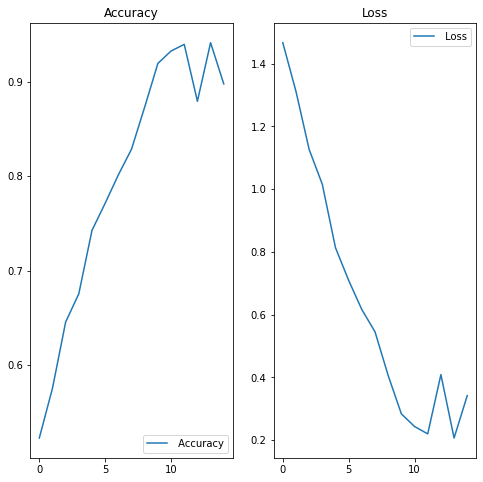

In [29]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label=' Accuracy')
plt.legend(loc='lower right')
plt.title('Accuracy')
plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label=' Loss')
plt.legend(loc='upper right')
plt.title('Loss')
plt.show()

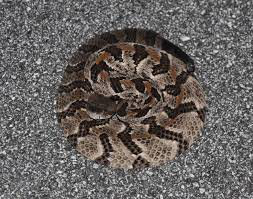

In [30]:
image_path = "/gdrive/My Drive/ff222657d8.jpg"
image = preprocessing.image.load_img(image_path)
image_array = preprocessing.image.img_to_array(image)
scaled_img = np.expand_dims(image_array, axis=0)
image

In [31]:
pred = model.predict(scaled_img)

In [32]:
output = class_names[np.argmax(pred)]

In [33]:
output

'crotalus-horridus'

In [34]:
model.save("snake.h5")